In [1]:
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as T
import torchvision.models as models

from pycocotools.coco import COCO

from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np

In [2]:
import os
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: c:\Users\user\Documents\python_ws\cardd-image-classification-benchmark\notebooks


In [3]:
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
data_dir = "../data/CarDD_COCO"

train_img_dir = os.path.join(data_dir, "train2017").replace("\\", "/")
val_img_dir   = os.path.join(data_dir, "val2017").replace("\\", "/")

train_ann_file = os.path.join(data_dir, "annotations", "instances_train2017.json").replace("\\", "/")
val_ann_file   = os.path.join(data_dir, "annotations", "instances_val2017.json").replace("\\", "/")

print(train_img_dir)
print(train_ann_file)


../data/CarDD_COCO/train2017
../data/CarDD_COCO/annotations/instances_train2017.json


In [6]:
coco_train = COCO(train_ann_file)

# 카테고리 정보 확인
cat_ids = sorted(coco_train.getCatIds())  # COCO 내부 category_id 목록
categories = coco_train.loadCats(cat_ids)

print("카테고리 개수:", len(categories))
for c in categories:
    print(f"id={c['id']}, name={c['name']}")

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
카테고리 개수: 6
id=1, name=dent
id=2, name=scratch
id=3, name=crack
id=4, name=glass shatter
id=5, name=lamp broken
id=6, name=tire flat


In [7]:
# COCO category_id → 0~(num_classes-1) 인덱스로 매핑
cat_id_to_idx = {cat_id: i for i, cat_id in enumerate(cat_ids)}
idx_to_cat_id = {i: cat_id for cat_id, i in cat_id_to_idx.items()}

cat_id_to_name = {c["id"]: c["name"] for c in categories}
class_names = [cat_id_to_name[cat_id] for cat_id in cat_ids]

num_classes = len(cat_ids)
print("num_classes:", num_classes)
print("class_names:", class_names)

num_classes: 6
class_names: ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']


In [8]:
class COCOSingleLabelDataset(Dataset):
    """
    COCO detection 형식에서
    - 이미지마다 bbox들이 여러 개 있어도
    - 가장 많이 등장한 category_id 하나만 라벨로 사용하는 단일 라벨 분류 Dataset
    """
    def __init__(self, img_dir, ann_file, cat_id_to_idx, transforms=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.transforms = transforms
        self.cat_id_to_idx = cat_id_to_idx

        # 모든 이미지 id
        self.img_ids = list(self.coco.imgs.keys())

        # 이미지별 단일 라벨 만들기
        self.labels = self._build_image_labels()

        # annotation이 하나도 없는 이미지는 제외
        self.img_ids = [img_id for img_id in self.img_ids if img_id in self.labels]

        print("유효한 이미지 개수:", len(self.img_ids))

    def _build_image_labels(self):
        labels = {}
        for img_id in self.img_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) == 0:
                # bbox가 없는 이미지 → 분류 학습에서 제외
                continue

            anns = self.coco.loadAnns(ann_ids)

            # cat_id 등장 횟수 세기
            counts = {}
            for ann in anns:
                cat_id = ann["category_id"]
                if cat_id not in self.cat_id_to_idx:
                    continue
                counts[cat_id] = counts.get(cat_id, 0) + 1

            if len(counts) == 0:
                continue

            # 가장 많이 등장한 category_id 선택
            rep_cat_id = max(counts, key=counts.get)
            label_idx = self.cat_id_to_idx[rep_cat_id]

            labels[img_id] = label_idx
        return labels

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(img_path).convert("RGB")
        label = self.labels[img_id]  # int

        if self.transforms is not None:
            img = self.transforms(img)

        # CrossEntropyLoss에서 target은 Long 타입 필요
        label = torch.tensor(label, dtype=torch.long)

        return img, label


In [9]:
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


In [10]:
train_dataset = COCOSingleLabelDataset(
    img_dir=train_img_dir,
    ann_file=train_ann_file,
    cat_id_to_idx=cat_id_to_idx,
    transforms=train_transform,
)

val_dataset = COCOSingleLabelDataset(
    img_dir=val_img_dir,
    ann_file=val_ann_file,
    cat_id_to_idx=cat_id_to_idx,
    transforms=val_transform,
)

len(train_dataset), len(val_dataset)


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
유효한 이미지 개수: 2816
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
유효한 이미지 개수: 810


(2816, 810)

In [11]:
# ============================
# 1) 클래스별 라벨 수 계산
# ============================

num_classes = len(class_names)

# 1) train_dataset에서 라벨만 모으기
train_labels = []

# 네 커스텀 Dataset에 .targets 같은 속성이 없으면 이렇게 직접 모으면 됨
for _, label in train_dataset:
    train_labels.append(int(label))

train_labels = np.array(train_labels)

# 2) 각 클래스별 개수 (0 ~ num_classes-1)
class_counts = np.bincount(train_labels, minlength=num_classes)
print("class_counts:", class_counts)

for i, cnt in enumerate(class_counts):
    print(f"{class_names[i]}: {cnt}")

class_counts: [ 967 1074  141  391   70  173]
dent: 967
scratch: 1074
crack: 141
glass shatter: 391
lamp broken: 70
tire flat: 173


In [12]:
eps = 1e-6                      # 0 나누기 방지용
inv_freq = 1.0 / (class_counts + eps)   # 개수 적을수록 값 큼

# 너무 스케일이 튀지 않게 전체를 적당히 맞춰줌 (선택)
class_weights = inv_freq / inv_freq.sum() * num_classes

print("class_weights:", class_weights)
for i, w in enumerate(class_weights):
    print(f"{class_names[i]}: {w:.3f}")

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

class_weights: [0.19585087 0.17633872 1.34317579 0.48436774 2.70553979 1.09472709]
dent: 0.196
scratch: 0.176
crack: 1.343
glass shatter: 0.484
lamp broken: 2.706
tire flat: 1.095


In [13]:
from torch.utils.data import WeightedRandomSampler

# ============================
# 2) WeightedRandomSampler 생성
# ============================

# 각 클래스의 샘플 비율을 반대로 적용 (개수 적을수록 weight↑)
class_sample_weights = 1.0 / (class_counts + 1e-6)

# 각 이미지에 해당하는 weight 부여
sample_weights = class_sample_weights[train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # epoch당 샘플 수
    replacement=True
)

In [14]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          sampler=sampler, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=0)

In [15]:
# 1) 사전학습된 ResNet34 불러오기
weights = models.ResNet34_Weights.IMAGENET1K_V1
model = models.resnet34(weights=weights)

# 2) 마지막 FC 레이어를 우리 클래스 개수에 맞게 교체
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

print(model.fc)

Linear(in_features=512, out_features=6, bias=True)


In [16]:
def set_trainable_layers_phase1(model):
    """
    Phase 1: fc만 학습 (백본 전체 freeze)
    """
    # 1) 모든 파라미터 freeze
    for param in model.parameters():
        param.requires_grad = False

    # 2) fc만 학습 가능하게
    for param in model.fc.parameters():
        param.requires_grad = True

    # 3) 학습 대상 파라미터만 optimizer에 전달
    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001,       # fc만 학습하니 약간 큰 LR 가능
        momentum=0.9,
        weight_decay=1e-4
    )

    # 스케줄러는 일단 간단히 StepLR로
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=5,
        gamma=0.1
    )

    return optimizer, scheduler


def set_trainable_layers_phase2(model):
    """
    Phase 2: layer4 + fc 학습 (상위 블록 파인튜닝)
    """
    # 1) 일단 다 freeze
    for param in model.parameters():
        param.requires_grad = False

    # 2) layer4 + fc만 unfreeze
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True

    # 3) 학습 대상만 optimizer에 전달
    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,      # Phase1보다 조금 더 작게
        momentum=0.9,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=15,
        eta_min=1e-5
    )

    return optimizer, scheduler


In [17]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)  # [B]

        optimizer.zero_grad()
        outputs = model(imgs)       # [B, num_classes]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        # 예측 (가장 높은 점수의 클래스)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total if total > 0 else 0

    return epoch_loss, epoch_acc

In [18]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total if total > 0 else 0

    return epoch_loss, epoch_acc

In [19]:
print("len(train_dataset):", len(train_dataset))
print("len(val_dataset):", len(val_dataset))

len(train_dataset): 2816
len(val_dataset): 810


In [20]:
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# without class_weight
criterion = nn.CrossEntropyLoss()

# Phase 1 설정
optimizer, scheduler = set_trainable_layers_phase1(model)

num_epochs_phase1 = 5

# 그래프용 기록 리스트
train_losses_p1, val_losses_p1 = [], []
train_accs_p1,  val_accs_p1  = [], []

print("=== Phase 1: fc만 학습 (백본 freeze) 시작 ===")
for epoch in range(1, num_epochs_phase1 + 1):
    print(f"\n[Phase1 Epoch {epoch}/{num_epochs_phase1}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss,   val_acc   = evaluate(model, val_loader, criterion, device)

    train_losses_p1.append(train_loss)
    val_losses_p1.append(val_loss)
    train_accs_p1.append(train_acc)
    val_accs_p1.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f},   Val Acc: {val_acc*100:.2f}%")
    print("Current LR:", optimizer.param_groups[0]['lr'])

    scheduler.step()

print("\n=== Phase 1 종료 ===")

=== Phase 1: fc만 학습 (백본 freeze) 시작 ===

[Phase1 Epoch 1/5]


Train Loss: 1.3844, Train Acc: 46.77%
Val   Loss: 1.3150,   Val Acc: 45.68%
Current LR: 0.001

[Phase1 Epoch 2/5]


Train Loss: 0.9528, Train Acc: 66.05%
Val   Loss: 1.2113,   Val Acc: 52.47%
Current LR: 0.001

[Phase1 Epoch 3/5]


Train Loss: 0.8857, Train Acc: 67.40%
Val   Loss: 1.1743,   Val Acc: 55.19%
Current LR: 0.001

[Phase1 Epoch 4/5]


Train Loss: 0.8411, Train Acc: 70.13%
Val   Loss: 1.2203,   Val Acc: 51.85%
Current LR: 0.001

[Phase1 Epoch 5/5]


Train Loss: 0.7984, Train Acc: 71.16%
Val   Loss: 1.2139,   Val Acc: 53.46%
Current LR: 0.001

=== Phase 1 종료 ===


In [21]:
# Phase 2 설정
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# without class_weight
criterion = nn.CrossEntropyLoss()
save_path = "../models/resnet34_sampler.pth"

# ========== Phase 2 Early Stopping 설정값 ==========
max_epochs = 20        # 최대 epoch (예: Phase2에서 10~15 설정)
min_epochs = 5         # 최소 epoch (이전보다 최소 몇 epoch은 돌려야 함)
patience = 4           # 몇 epoch 동안 개선 없으면 stop
min_delta = 0.0001      # 개선으로 인정할 최소 변화량

# 상태 변수
best_val_loss = float("inf")
no_improve = 0
best_epoch = 0

optimizer, scheduler = set_trainable_layers_phase2(model)

train_losses_p2, val_losses_p2 = [], []
train_accs_p2,  val_accs_p2  = [], []

print("=== Phase 2: layer4 + fc 파인튜닝 시작 ===")

for epoch in range(1, max_epochs + 1):
    print(f"\n[Phase2 Epoch {epoch}/{max_epochs}]")

    # ---- Train & Validation ----
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss,   val_acc   = evaluate(model, val_loader, criterion, device)

    # ---- 기록 저장 ----
    train_losses_p2.append(train_loss)
    val_losses_p2.append(val_loss)
    train_accs_p2.append(train_acc)
    val_accs_p2.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f},   Val Acc: {val_acc*100:.2f}%")
    print("Current LR:", optimizer.param_groups[0]['lr'])

    # ---- Early Stopping 체크 ----
    # 개선 조건: 이전 best보다 min_delta 이상 감소하면
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch
        no_improve = 0

        # 🔥 Best 모델 저장
        torch.save({
            "model_state_dict": model.state_dict(),
            "cat_id_to_idx": cat_id_to_idx,
            "idx_to_cat_id": idx_to_cat_id,
            "class_names": class_names,
        }, save_path)

        print(f">>> Best model updated! (Val Loss={val_loss:.4f}) saved to {save_path}")

    else:
        no_improve += 1
        print(f"No improvement count: {no_improve}/{patience}")

    # ---- Early stopping 발동 ----
    if epoch > min_epochs and no_improve >= patience:
        print(f"### Early stopping triggered at epoch {epoch} (best epoch = {best_epoch}) ###")
        break

    # ---- Scheduler step ----
    scheduler.step()

print("\n=== Phase 2 종료 ===")
print(f"Best Val Loss: {best_val_loss:.4f} (epoch {best_epoch})")


=== Phase 2: layer4 + fc 파인튜닝 시작 ===

[Phase2 Epoch 1/20]


Train Loss: 0.6892, Train Acc: 75.07%
Val   Loss: 0.9450,   Val Acc: 64.57%
Current LR: 0.001
>>> Best model updated! (Val Loss=0.9450) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 2/20]


Train Loss: 0.5515, Train Acc: 81.07%
Val   Loss: 0.9096,   Val Acc: 65.68%
Current LR: 0.0009891830623632338
>>> Best model updated! (Val Loss=0.9096) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 3/20]


Train Loss: 0.4647, Train Acc: 83.88%
Val   Loss: 0.8812,   Val Acc: 65.56%
Current LR: 0.0009572050015330873
>>> Best model updated! (Val Loss=0.8812) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 4/20]


Train Loss: 0.3938, Train Acc: 85.80%
Val   Loss: 0.8707,   Val Acc: 66.54%
Current LR: 0.0009054634122155989
>>> Best model updated! (Val Loss=0.8707) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 5/20]


Train Loss: 0.3528, Train Acc: 87.64%
Val   Loss: 0.8278,   Val Acc: 66.91%
Current LR: 0.0008362196501476348
>>> Best model updated! (Val Loss=0.8278) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 6/20]


Train Loss: 0.3393, Train Acc: 88.10%
Val   Loss: 0.8343,   Val Acc: 68.40%
Current LR: 0.0007524999999999999
No improvement count: 1/4

[Phase2 Epoch 7/20]


Train Loss: 0.3054, Train Acc: 88.88%
Val   Loss: 0.8064,   Val Acc: 69.75%
Current LR: 0.0006579634122155989
>>> Best model updated! (Val Loss=0.8064) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 8/20]


Train Loss: 0.2728, Train Acc: 90.38%
Val   Loss: 0.8017,   Val Acc: 70.37%
Current LR: 0.0005567415893174885
>>> Best model updated! (Val Loss=0.8017) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 9/20]


Train Loss: 0.2498, Train Acc: 91.26%
Val   Loss: 0.7986,   Val Acc: 70.62%
Current LR: 0.00045325841068251166
>>> Best model updated! (Val Loss=0.7986) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 10/20]


Train Loss: 0.2363, Train Acc: 91.80%
Val   Loss: 0.7964,   Val Acc: 71.48%
Current LR: 0.00035203658778440114
>>> Best model updated! (Val Loss=0.7964) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 11/20]


Train Loss: 0.2451, Train Acc: 91.65%
Val   Loss: 0.8057,   Val Acc: 70.25%
Current LR: 0.00025750000000000013
No improvement count: 1/4

[Phase2 Epoch 12/20]


Train Loss: 0.2394, Train Acc: 91.76%
Val   Loss: 0.8130,   Val Acc: 69.26%
Current LR: 0.00017378034985236532
No improvement count: 2/4

[Phase2 Epoch 13/20]


Train Loss: 0.2302, Train Acc: 91.97%
Val   Loss: 0.8047,   Val Acc: 70.86%
Current LR: 0.00010453658778440104
No improvement count: 3/4

[Phase2 Epoch 14/20]


Train Loss: 0.2396, Train Acc: 91.69%
Val   Loss: 0.7918,   Val Acc: 71.36%
Current LR: 5.2794998466912506e-05
>>> Best model updated! (Val Loss=0.7918) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 15/20]


Train Loss: 0.2314, Train Acc: 92.54%
Val   Loss: 0.7880,   Val Acc: 71.73%
Current LR: 2.081693763676618e-05
>>> Best model updated! (Val Loss=0.7880) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 16/20]


Train Loss: 0.2420, Train Acc: 91.16%
Val   Loss: 0.7935,   Val Acc: 71.60%
Current LR: 1e-05
No improvement count: 1/4

[Phase2 Epoch 17/20]


Train Loss: 0.2376, Train Acc: 92.05%
Val   Loss: 0.7820,   Val Acc: 71.11%
Current LR: 2.0816937636766185e-05
>>> Best model updated! (Val Loss=0.7820) saved to ../models/resnet34_sampler.pth

[Phase2 Epoch 18/20]


Train Loss: 0.2415, Train Acc: 92.05%
Val   Loss: 0.7875,   Val Acc: 71.73%
Current LR: 5.279499846691257e-05
No improvement count: 1/4

[Phase2 Epoch 19/20]


Train Loss: 0.2242, Train Acc: 92.61%
Val   Loss: 0.7922,   Val Acc: 72.10%
Current LR: 0.00010453658778440102
No improvement count: 2/4

[Phase2 Epoch 20/20]


Train Loss: 0.2208, Train Acc: 92.72%
Val   Loss: 0.7842,   Val Acc: 71.85%
Current LR: 0.00017378034985236507
No improvement count: 3/4

=== Phase 2 종료 ===
Best Val Loss: 0.7820 (epoch 17)


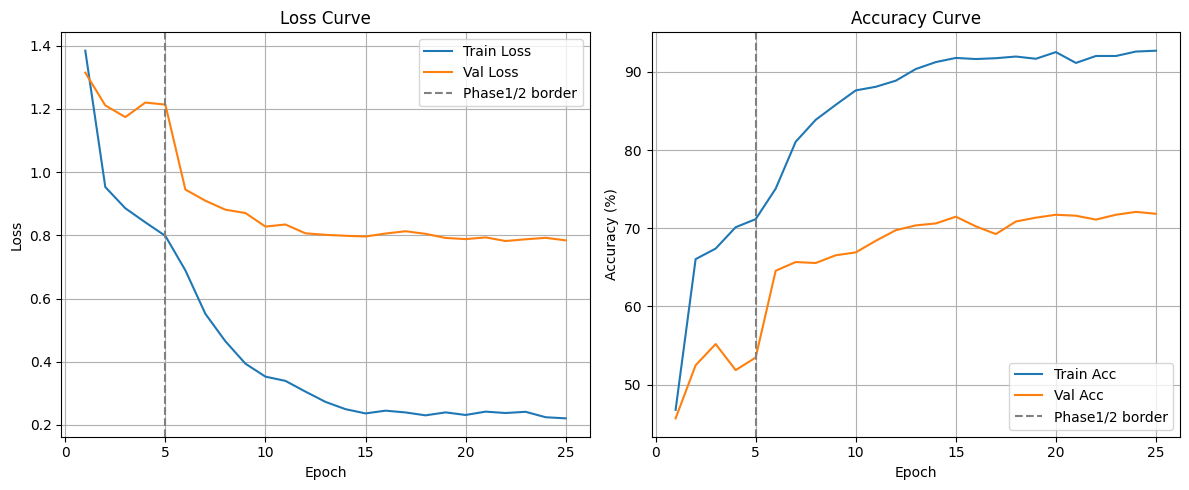

In [22]:
import matplotlib.pyplot as plt

train_losses = train_losses_p1 + train_losses_p2
val_losses   = val_losses_p1   + val_losses_p2
train_accs   = train_accs_p1   + train_accs_p2
val_accs     = val_accs_p1     + val_accs_p2

total_epochs = len(train_losses)
epochs = range(1, total_epochs + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.axvline(x=len(train_losses_p1), color='gray', linestyle='--', label='Phase1/2 border')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, [a*100 for a in train_accs], label="Train Acc")
plt.plot(epochs, [a*100 for a in val_accs],   label="Val Acc")
plt.axvline(x=len(train_losses_p1), color='gray', linestyle='--', label='Phase1/2 border')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()

filepath = '../outputs/04_resnet34_sampler/Accuracy Curve.png'

# 디렉토리 경로 추출
directory = os.path.dirname(filepath)

# 폴더가 없으면 생성 (중첩 폴더도 자동 생성)
os.makedirs(directory, exist_ok=True)

# 저장
plt.savefig(filepath, dpi=300)

plt.show()


In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools


In [24]:
def collect_predictions(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_images = []  # 오분류 시각화용으로 일부 저장

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)              # [B, num_classes]
            probs = torch.softmax(logits, 1)  # [B, num_classes]
            confs, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_images.extend(imgs.cpu())  # 원하면 이미지도 저장

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_images = torch.stack(all_images)

    return all_labels, all_preds, all_probs, all_images


In [25]:
y_true, y_pred, y_probs, val_imgs = collect_predictions(model, val_loader, device)
print("예측 개수:", len(y_true))

예측 개수: 810


In [26]:
acc = (y_true == y_pred).mean()
print(f"Validation Accuracy: {acc*100:.2f}%\n")

print("=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=3
))

Validation Accuracy: 71.85%

=== Classification Report ===
               precision    recall  f1-score   support

         dent      0.733     0.614     0.668       277
      scratch      0.713     0.756     0.734       308
        crack      0.354     0.370     0.362        46
glass shatter      0.858     0.991     0.920       110
  lamp broken      0.478     0.440     0.458        25
    tire flat      0.792     0.955     0.866        44

     accuracy                          0.719       810
    macro avg      0.655     0.688     0.668       810
 weighted avg      0.716     0.719     0.714       810



In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(8, 8)):
    if normalize:
        cm_to_show = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    else:
        cm_to_show = cm

    plt.figure(figsize=figsize)
    plt.imshow(cm_to_show, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm_to_show.max() / 2.

    for i, j in itertools.product(range(cm_to_show.shape[0]), range(cm_to_show.shape[1])):
        plt.text(j, i, format(cm_to_show[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_to_show[i, j] > thresh else "black",
                 fontsize=8)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'../outputs/04_resnet34_sampler/{title}.png', dpi=300)
    plt.show()


In [28]:
cm = confusion_matrix(y_true, y_pred)   # shape: [num_classes, num_classes]
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 행 기준 정규화

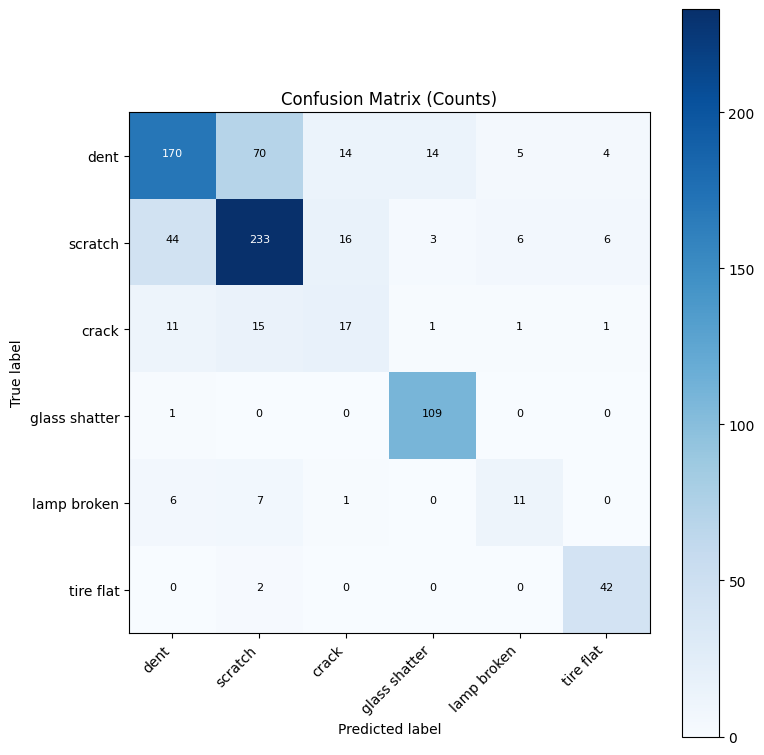

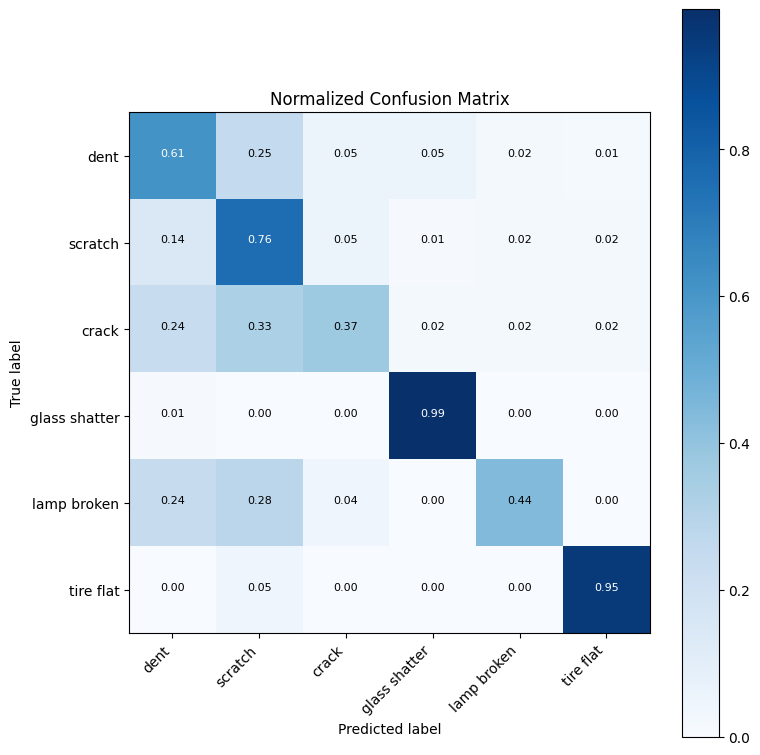

In [29]:
# 원본 카운트
plot_confusion_matrix(cm, class_names,
                      normalize=False,
                      title='Confusion Matrix (Counts)')

# 정규화 버전
plot_confusion_matrix(cm, class_names,
                      normalize=True,
                      title='Normalized Confusion Matrix')


In [30]:
mis_idx = np.where(y_true != y_pred)[0]
len(mis_idx)


228

In [31]:
import random

# 너무 많으면 랜덤 샘플링
sample_mis_idx = mis_idx[:16] if len(mis_idx) > 16 else mis_idx

def denormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    ToTensor + Normalize된 이미지를 다시 시각화용으로 복원
    img_tensor: [C, H, W]
    """
    img = img_tensor.clone().numpy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))  # [H, W, C]
    return img


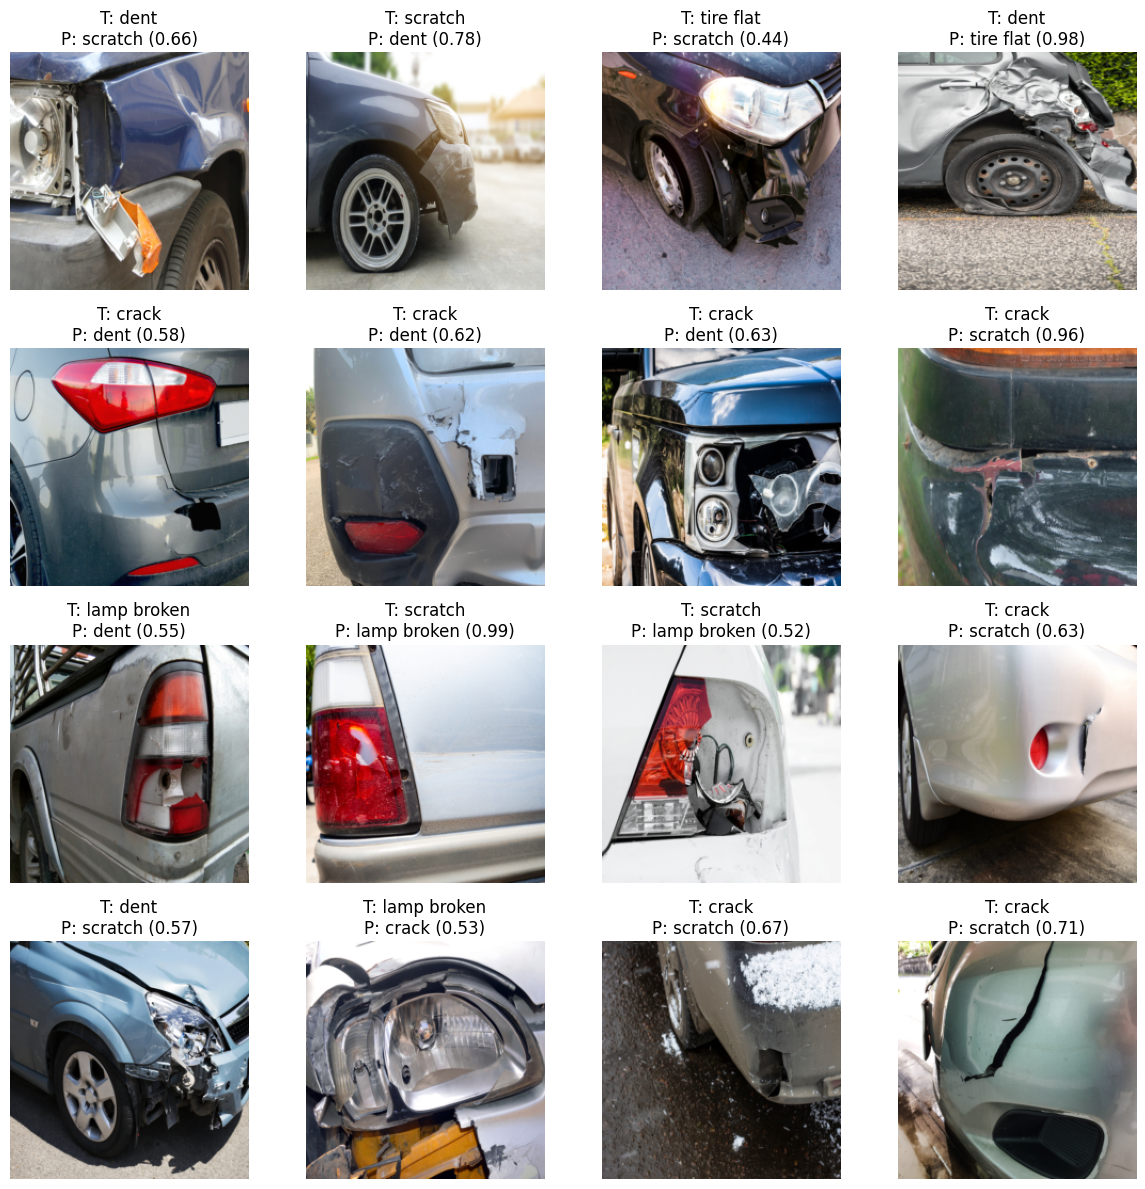

In [32]:
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_mis_idx[:16]):
    img = denormalize(val_imgs[idx])
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    conf = y_probs[idx, y_pred[idx]]

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_label}\nP: {pred_label} ({conf:.2f})")
plt.tight_layout()
plt.show()


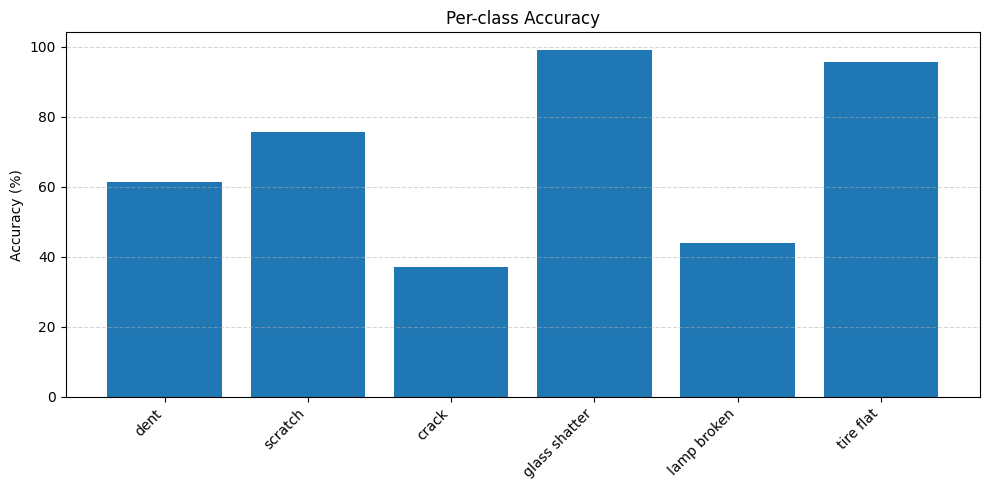

In [33]:
num_classes = len(class_names)
class_acc = []

for cls_idx in range(num_classes):
    cls_mask = (y_true == cls_idx)
    if cls_mask.sum() == 0:
        acc_c = 0.0
    else:
        acc_c = (y_pred[cls_mask] == y_true[cls_mask]).mean()
    class_acc.append(acc_c)

plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), [a * 100 for a in class_acc])
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Per-class Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../outputs/04_resnet34_sampler/Per-class Accuracy.png', dpi=300)
plt.show()
